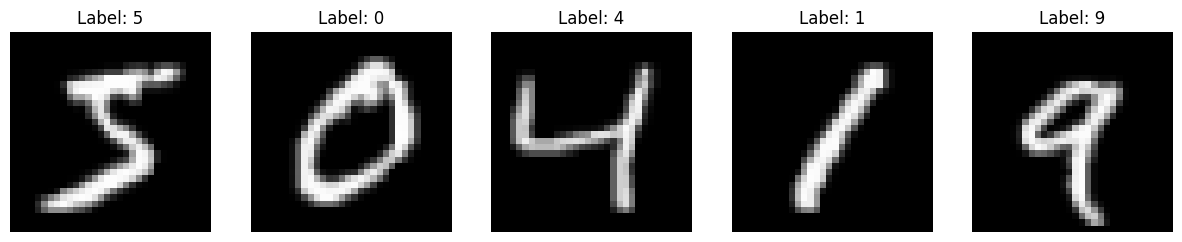

Epoch 1/2
141/141 ━━━━━━━━━━━━━━━━━━━━ 35s 242ms/step - accuracy: 0.1777 - loss: 2.2599 - val_accuracy: 0.5870 - val_loss: 1.7361
Epoch 2/2
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 283ms/step - accuracy: 0.4222 - loss: 1.7515 - val_accuracy: 0.7100 - val_loss: 1.3979
Epoch 1/2
141/141 ━━━━━━━━━━━━━━━━━━━━ 65s 424ms/step - accuracy: 0.1453 - loss: 3.3382 - val_accuracy: 0.4480 - val_loss: 1.7747
Epoch 2/2
141/141 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.3722 - loss: 1.8567 - val_accuracy: 0.6000 - val_loss: 1.5205
VGG16 Model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 159ms/step - accuracy: 0.6854 - loss: 1.4205
Test Accuracy: 70.37%
Test Loss: 1.4161
ResNet50 Model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - accuracy: 0.5916 - loss: 1.5539
Test Accuracy: 61.19%
Test Loss: 1.5438
Confusion Matrix for VGG16 Model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step


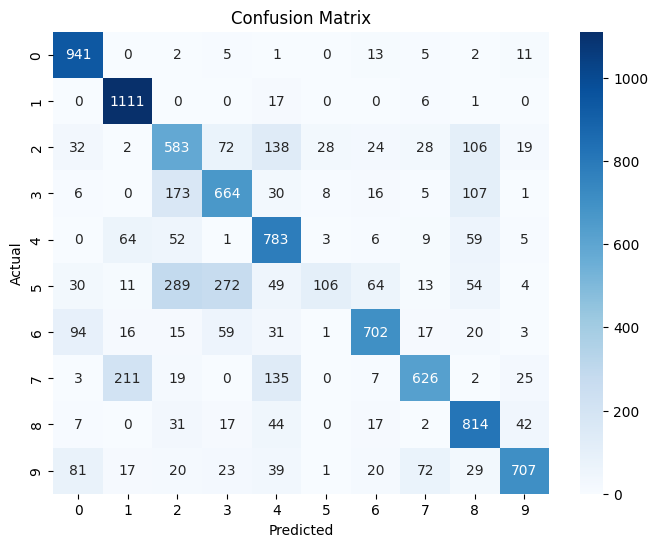

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       980
           1       0.78      0.98      0.87      1135
           2       0.49      0.56      0.53      1032
           3       0.60      0.66      0.63      1010
           4       0.62      0.80      0.70       982
           5       0.72      0.12      0.20       892
           6       0.81      0.73      0.77       958
           7       0.80      0.61      0.69      1028
           8       0.68      0.84      0.75       974
           9       0.87      0.70      0.77      1009

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.68     10000
weighted avg       0.71      0.70      0.68     10000

Confusion Matrix for ResNet50 Model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 150ms/step


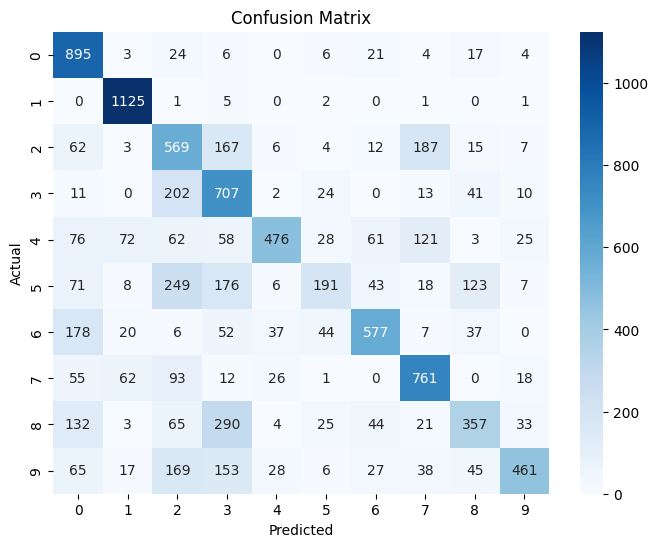

              precision    recall  f1-score   support

           0       0.58      0.91      0.71       980
           1       0.86      0.99      0.92      1135
           2       0.40      0.55      0.46      1032
           3       0.43      0.70      0.54      1010
           4       0.81      0.48      0.61       982
           5       0.58      0.21      0.31       892
           6       0.74      0.60      0.66       958
           7       0.65      0.74      0.69      1028
           8       0.56      0.37      0.44       974
           9       0.81      0.46      0.59      1009

    accuracy                           0.61     10000
   macro avg       0.64      0.60      0.59     10000
weighted avg       0.64      0.61      0.60     10000



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

import tensorflow as tf
from tensorflow.keras import mixed_precision


policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


x_train_resized = tf.image.resize(x_train, [32, 32])
x_test_resized = tf.image.resize(x_test, [32, 32])


x_train_rgb = tf.image.grayscale_to_rgb(x_train_resized)
x_test_rgb = tf.image.grayscale_to_rgb(x_test_resized)


x_train_rgb = x_train_rgb / 255.0
x_test_rgb = x_test_rgb / 255.0


y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


fig, axes = plt.subplots(1, 5, figsize=(15, 6))
for i, ax in enumerate(axes):
    ax.imshow(x_train_rgb[i])
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.show()


def build_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # 10 classes for MNIST
    ])
    return model

def build_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  
    ])
    return model


def train_and_evaluate_optimized(model, learning_rate=0.001, epochs=2, batch_size=64):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        x_train_rgb[:10000], y_train_cat[:10000],  
        epochs=epochs,
        validation_split=0.1,  
        batch_size=batch_size
    )
    return history


vgg16_model = build_vgg16_model()
resnet50_model = build_resnet50_model()


history_vgg16 = train_and_evaluate_optimized(vgg16_model, learning_rate=0.0001, epochs=2)
history_resnet50 = train_and_evaluate_optimized(resnet50_model, learning_rate=0.0001, epochs=2)


def evaluate_model(model, x_data, y_data):
    test_loss, test_accuracy = model.evaluate(x_data, y_data)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    return test_loss, test_accuracy

print("VGG16 Model:")
evaluate_model(vgg16_model, x_test_rgb, y_test_cat)
print("ResNet50 Model:")
evaluate_model(resnet50_model, x_test_rgb, y_test_cat)


def plot_confusion_matrix(model, x_data, y_true):
    y_pred = np.argmax(model.predict(x_data), axis=-1)
    y_true = np.argmax(y_true, axis=-1)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(y_true, y_pred))

print("Confusion Matrix for VGG16 Model:")
plot_confusion_matrix(vgg16_model, x_test_rgb, y_test_cat)

print("Confusion Matrix for ResNet50 Model:")
plot_confusion_matrix(resnet50_model, x_test_rgb, y_test_cat)
